In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from datetime import datetime

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load

In [2]:
data = np.load("/kaggle/input/mars-training-set/mars_for_students.npz")

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

input_shape = X_train_val.shape[1:]
num_classes = len(np.unique(y_train_val))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

print(f"\nShape of X_train: {X_train_val.shape}")
print(f"Shape of y_train: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")


Input shape: (64, 128)
Number of classes: 5

Shape of X_train: (2615, 64, 128)
Shape of y_train: (2615, 64, 128)
Shape of X_test: (10022, 64, 128)


# Inspect Images

Training set images: 2615


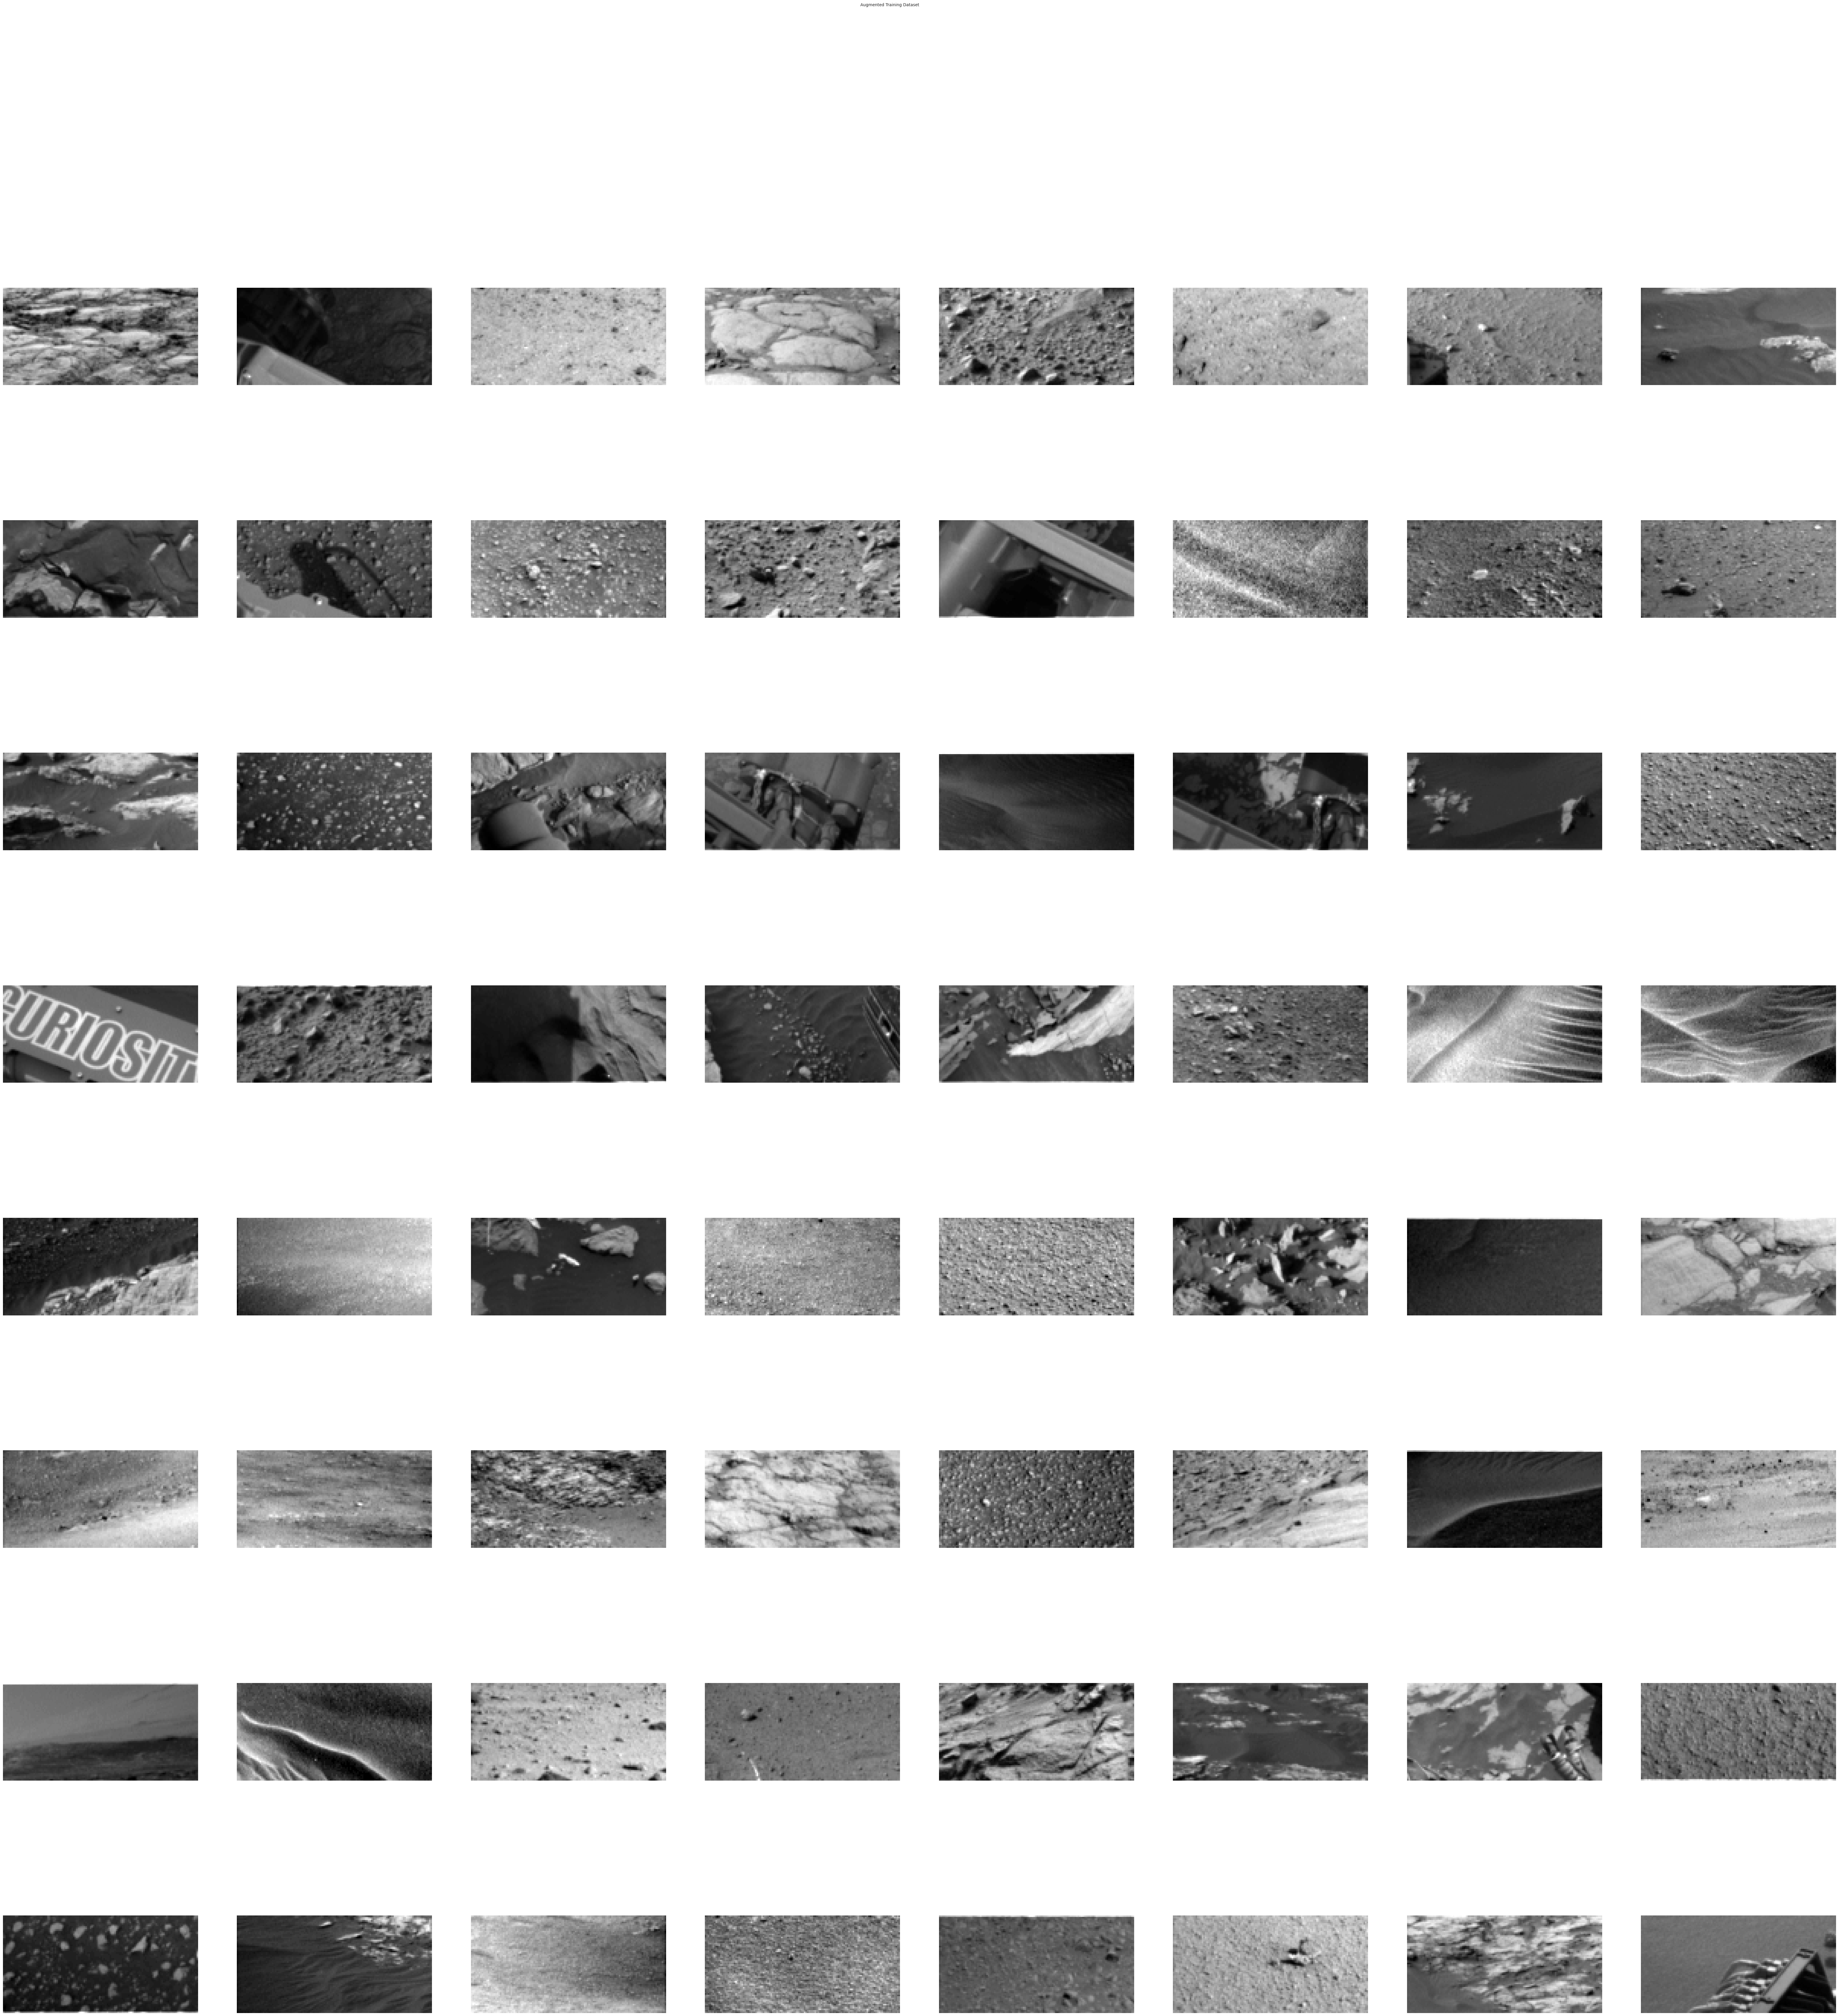

In [3]:
def visualize_dataset(dataset, title, image_size=(10, 10), grid_size=(8, 8)):
    print("Training set images:", len(dataset))

    num_images_to_plot = grid_size[0] * grid_size[1]
    random_indices = random.sample(range(len(dataset)), num_images_to_plot)
    sampled_images = [dataset[i] for i in random_indices]
    
    figsize = (grid_size[1] * image_size[0], grid_size[0] * image_size[1])
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=10)
    for i, image in enumerate(sampled_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(image, cmap="gray")  # Grayscale visualization
        plt.axis("off")
    plt.show()

visualize_dataset(X_train_val, "Augmented Training Dataset")

## 👽 Detect Outliers

In [4]:
# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train_val):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

Duplicate images found!


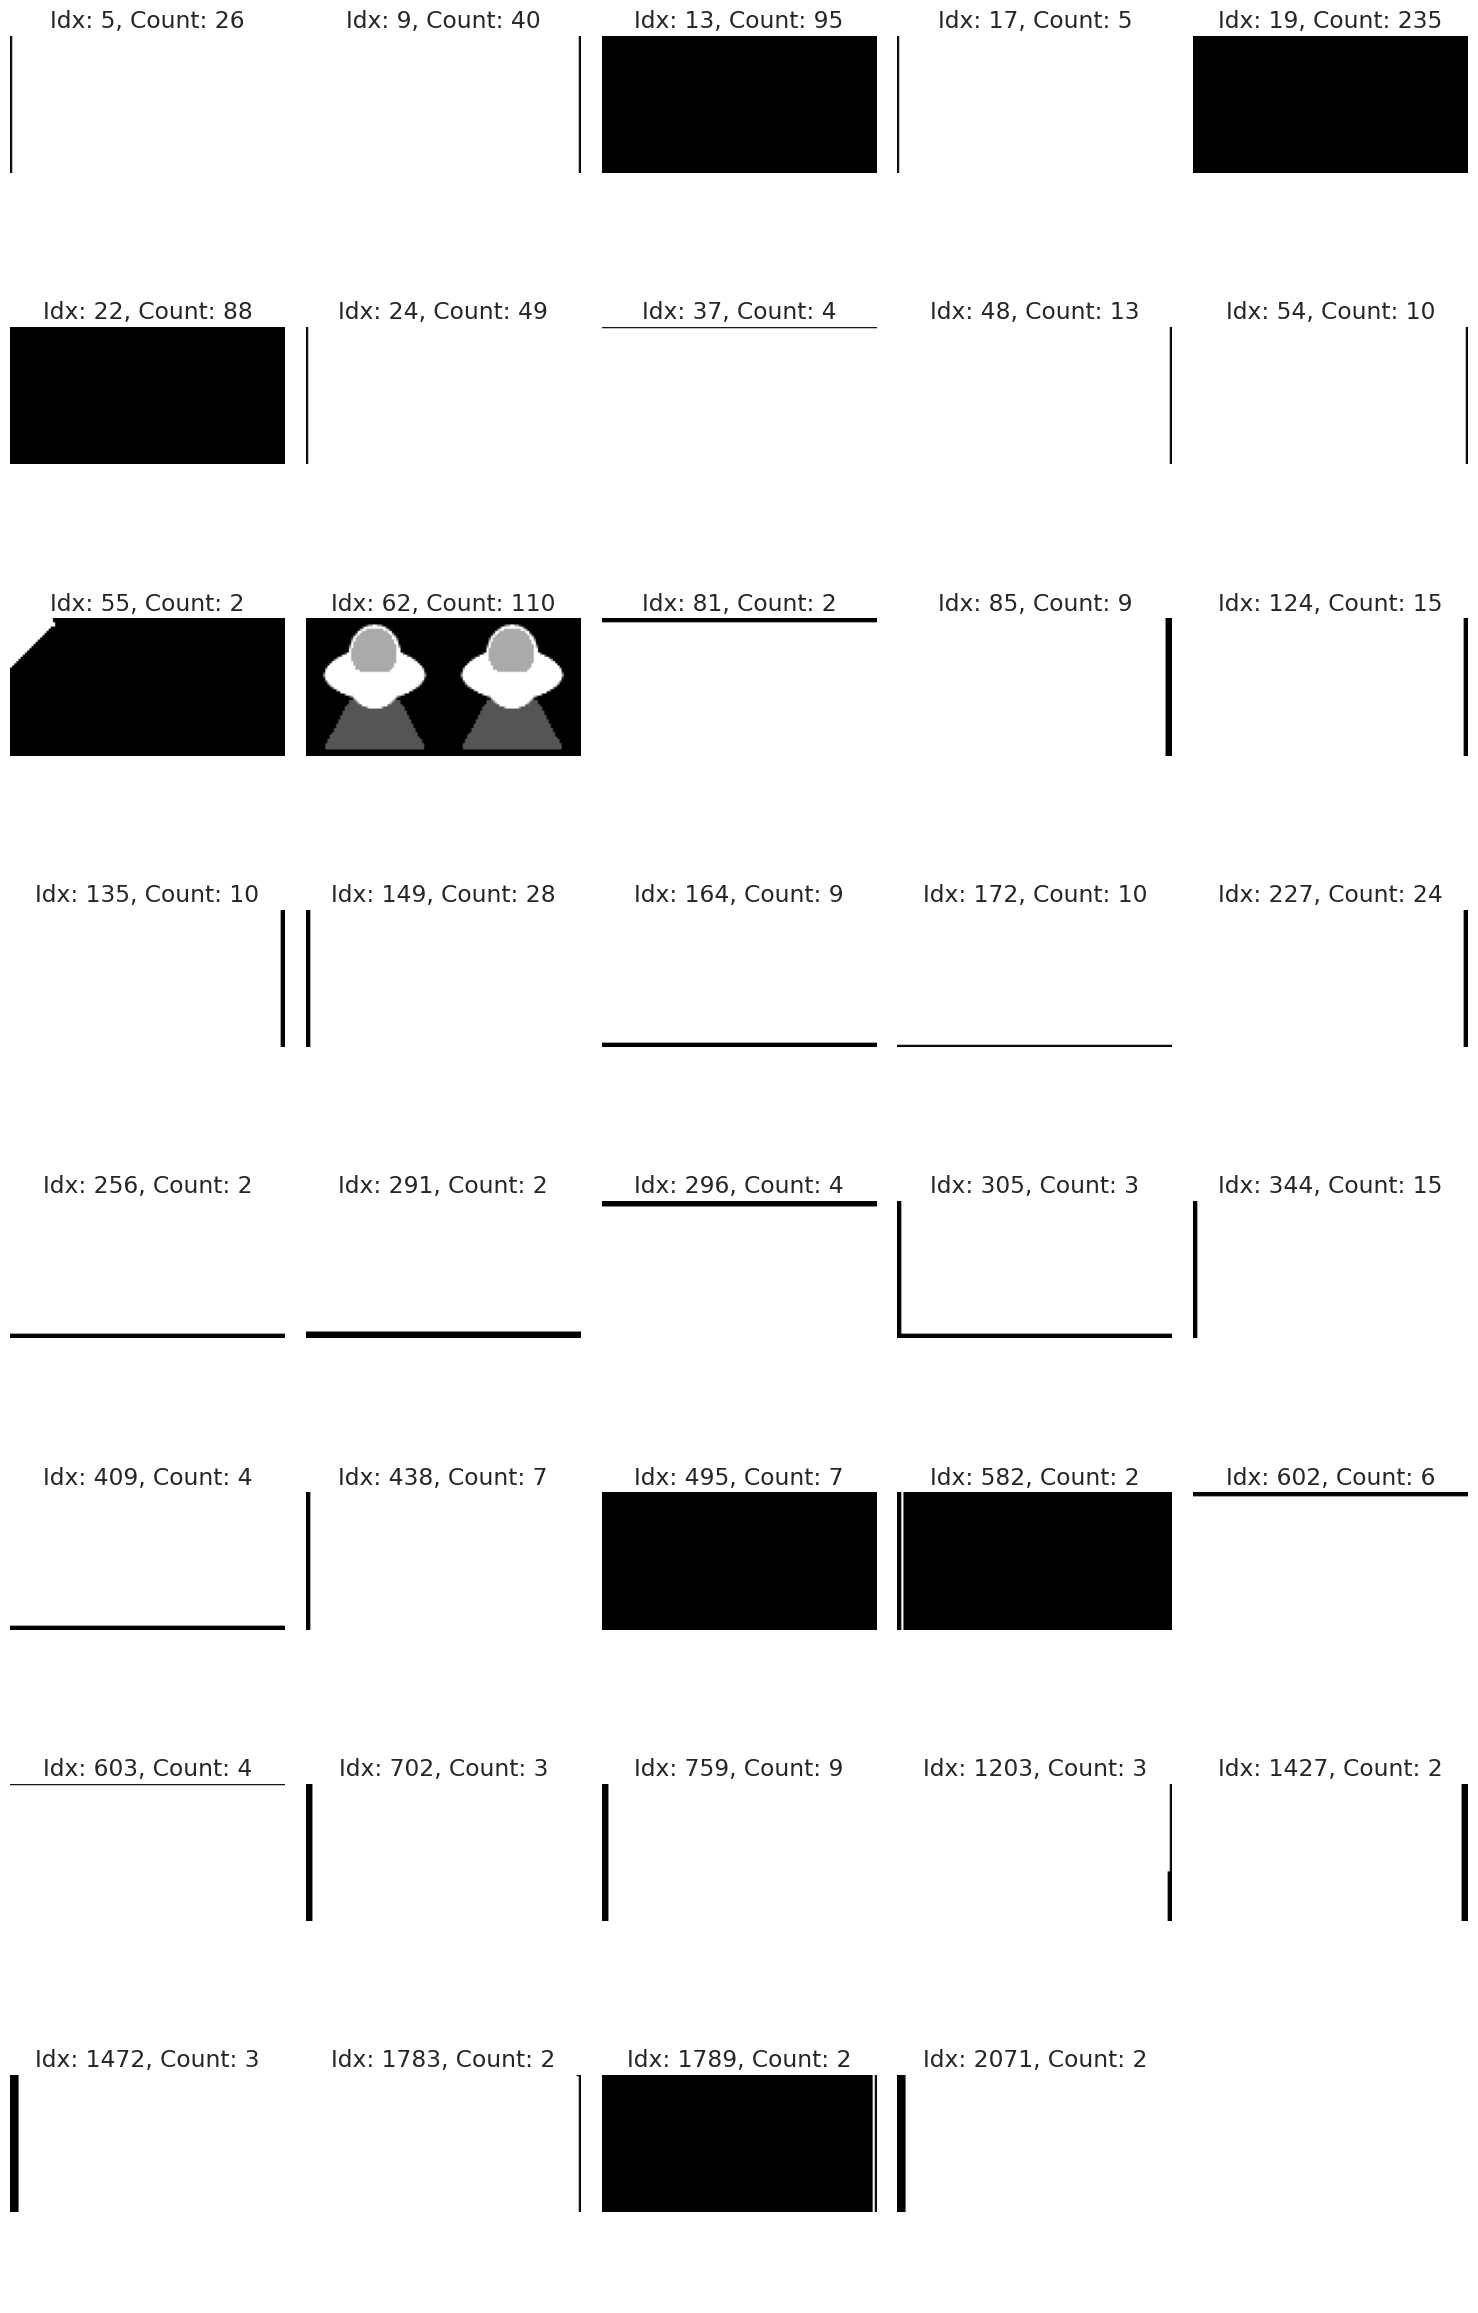

In [5]:
# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        if y_train_val[representative_idx].ndim == 3: 
            ax.imshow(y_train_val[representative_idx])
        else: 
            ax.imshow(y_train_val[representative_idx], cmap='gray')
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

## Inspect an index

In [6]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

In [7]:
def apply_colormap(label, colormap=None):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

Hash for image at index 2071: 17fec901f6ed4082a70668bf7a334b37


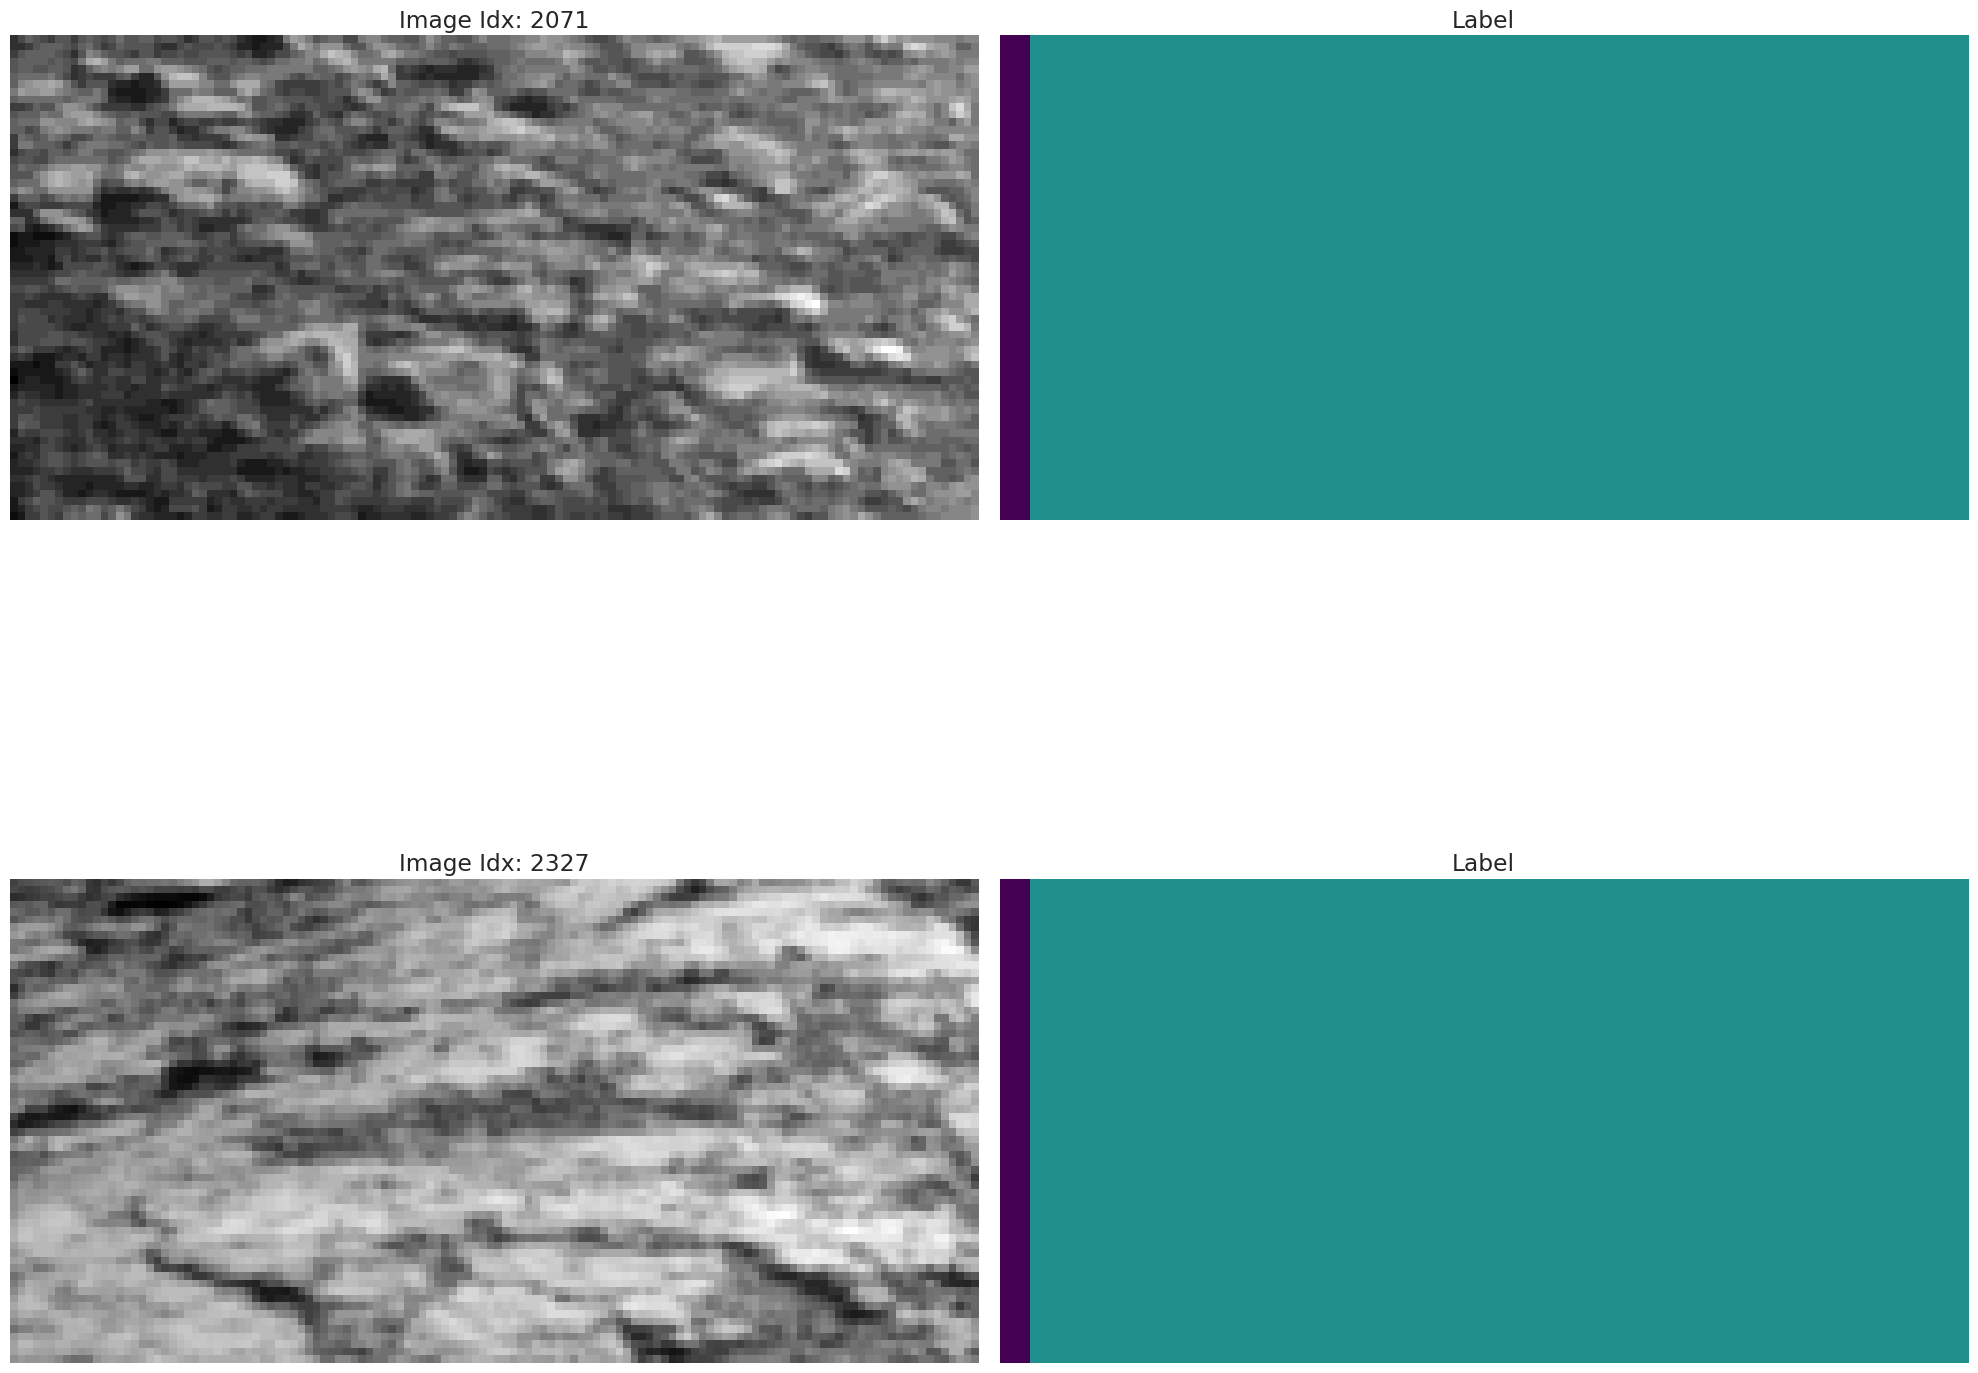

In [8]:
index_of_interest = 2071

# Function to get images associated with a specific index
def get_images_by_index(index):
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Get images and duplicates
img_hash, associated_indices = get_images_by_index(index_of_interest)

if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    num_images = len(associated_indices)
    cols = 2  # Show image and label side-by-side
    rows = num_images  # One row per image-label pair
    
    # Create colormap for labels
    num_classes = len(np.unique(y_train_val))
    colormap = create_segmentation_colormap(num_classes)

    # Larger figure size for better visuals
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
    axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access

    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax_image = axes[i, 0]
        ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
        ax_image.set_title(f"Image Idx: {idx}")
        ax_image.axis('off')

        # Plot the label
        ax_label = axes[i, 1]
        colored_label = apply_colormap(y_train_val[idx], colormap)
        ax_label.imshow(colored_label)
        ax_label.set_title("Label")
        ax_label.axis('off')


    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")


In [9]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128)


## 🔄 Process Data

In [10]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 50

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 0.2

## dividing in train and validaiton set

In [11]:
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)

# Display dataset information
print(f"\nNumber of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Number of images:
Training set: 2004
Validation set: 501
Test set: 10022


In [12]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


## normalizing the data

In [13]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.expand_dims(X, axis=-1)  
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0

    y = tf.expand_dims(y, axis=-1)
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

# preprocessing also the test set
X_test = X_test[..., np.newaxis] / 255.0

In [14]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

## defining augmentation

In [15]:
# Define augmentation
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


In [16]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Preprocess immages and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping: change the labels
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment: #apply random flip
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data (do it now and not at training time)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [17]:
# Create the datasets
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


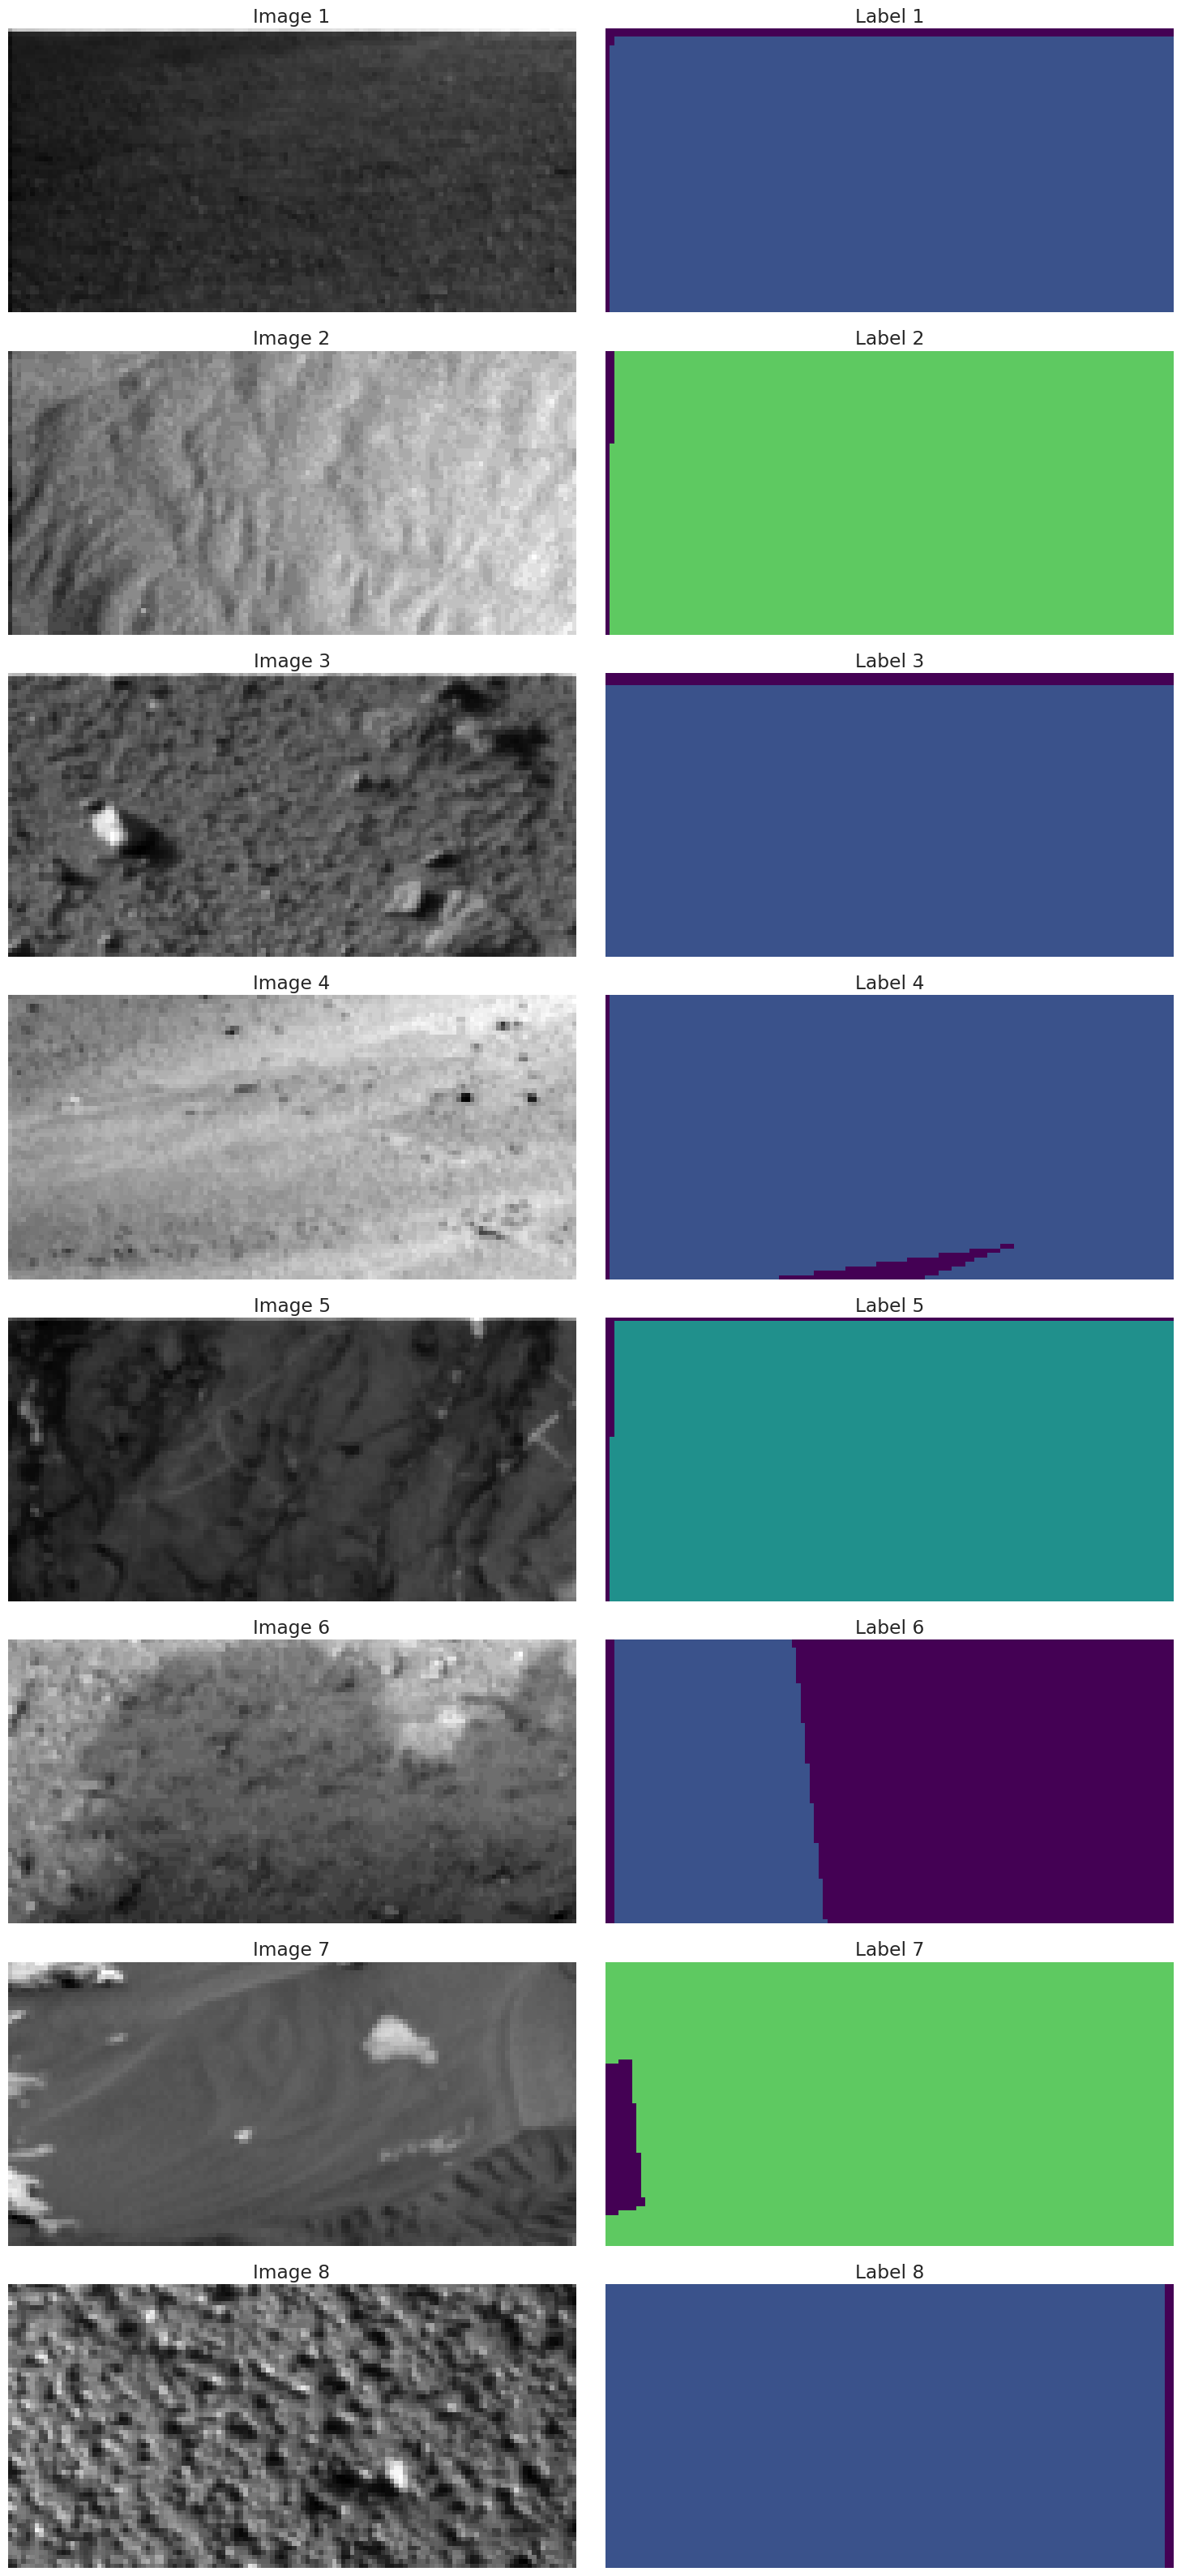

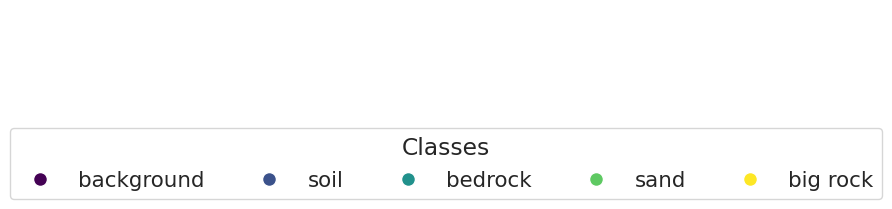

In [18]:
# Plot real image and ground truth (reduced resolution)
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(category_map)  # Ensure colormap covers all classes, including the background
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original grayscale image (no colormap)
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j], cmap='gray')  # Use 'gray' cmap for the images (ensure grayscale)
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label (apply colormap only to labels)
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)  # Apply colormap to the labels only
            plt.imshow(colored_label)  # Show the colored label
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

    handles = []
    # After all images have been plotted, add the legend once
    for label_idx in category_map:
        color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))
    
    # Create a single legend displayed at the bottom
    fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
    ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
    ax.axis('off')
    plt.show()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=8)

## 🛠️ Model Definition and Training

In [19]:
"""
ResUNet++ architecture in Keras TensorFlow
"""
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

def build_model():
    n_filters = [16, 32, 64, 128, 256]
    inputs = Input(shape=(64,128,1))

    c0 = inputs
    c1 = stem_block(c0, n_filters[0], strides=1)

    ## Encoder
    c2 = resnet_block(c1, n_filters[1], strides=2)
    c3 = resnet_block(c2, n_filters[2], strides=2)
    c4 = resnet_block(c3, n_filters[3], strides=2)

    ## Bridge
    b1 = aspp_block(c4, n_filters[4])

    ## Decoder
    d1 = attetion_block(c3, b1)
    d1 = UpSampling2D((2, 2))(d1)
    d1 = Concatenate()([d1, c3])
    d1 = resnet_block(d1, n_filters[3])

    d2 = attetion_block(c2, d1)
    d2 = UpSampling2D((2, 2))(d2)
    d2 = Concatenate()([d2, c2])
    d2 = resnet_block(d2, n_filters[2])

    d3 = attetion_block(c1, d2)
    d3 = UpSampling2D((2, 2))(d3)
    d3 = Concatenate()([d3, c1])
    d3 = resnet_block(d3, n_filters[1])

    ## output
    outputs = aspp_block(d3, n_filters[0])
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(outputs)

    ## Model
    model = Model(inputs, outputs)
    return model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 128,   │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │         32 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ conv2d_1[0][0],   │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ add[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 16)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 2)   │         32 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 16)  │         32 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 128,   │          0 │ add[0][0],        │
│                     │ 16)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         64 │ multiply[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │      4,640 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 64,    │          0 │ batch_normalizat

 Total params: 4,070,133 (15.53 MB)

 Trainable params: 4,062,741 (15.50 MB)

 Non-trainable params: 7,392 (28.88 KB)

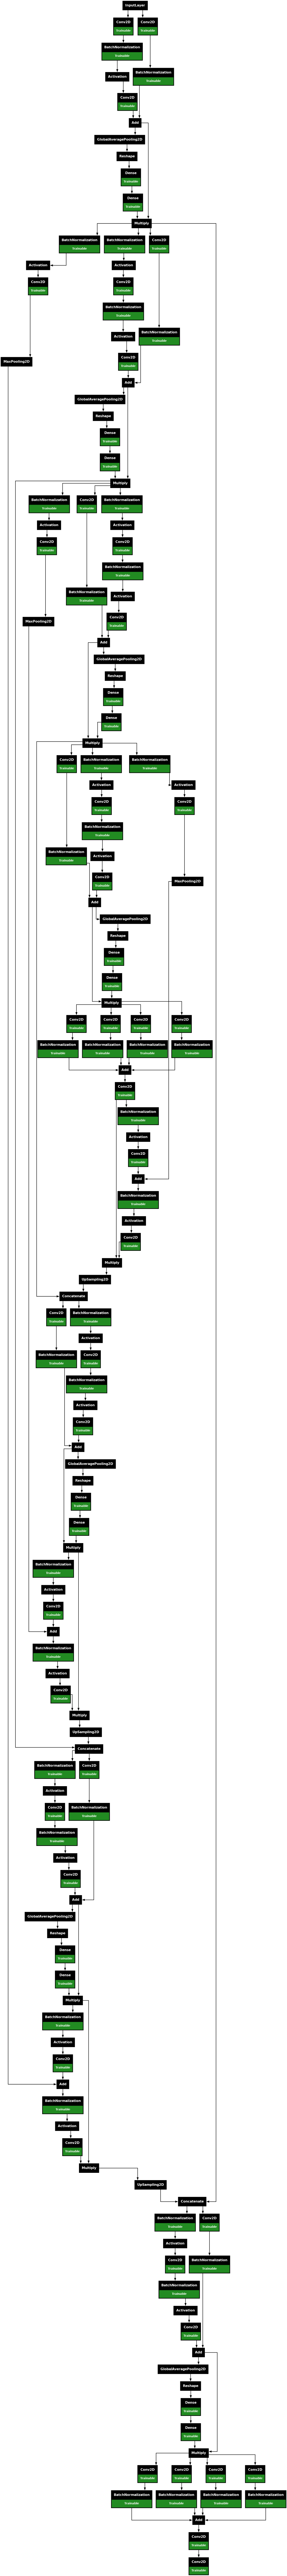

In [20]:
model = build_model()
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=False, show_trainable=False)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [21]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
#useful for debugging ex. I'm stuck in a local minima where the less represented class is never predicted
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=2):
        super().__init__()
        self.val_dataset = val_dataset  # The validation dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get a batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                for i in range(1):
                    idx = 3 if i==0 else 14
                    image = image_batch[idx]  # Take the first image from the batch (oppure 13)
                    label = label_batch[idx]  # Take the first label from the batch
    
                    # Add batch dimension to the image (if necessary)
                    image = tf.expand_dims(image, 0)
    
                    # Perform prediction
                    pred = self.model.predict(image, verbose=0)
                    y_pred = tf.math.argmax(pred, axis=-1)
                    y_pred = y_pred.numpy()  # Convert to NumPy array for visualization
    
                    # Create colormap (assuming a predefined function `create_segmentation_colormap`)
                    num_classes = NUM_CLASSES
                    colormap = create_segmentation_colormap(num_classes)
    
                    # Plot the results
                    plt.figure(figsize=(16, 4))
    
                    # Input image
                    plt.subplot(i+1, 3, 1)
                    plt.imshow(image[0], cmap='gray')
                    plt.title("Input Image")
                    plt.axis('off')
    
                    # Ground truth
                    plt.subplot(i+1, 3, 2)
                    colored_label = apply_colormap(label.numpy(), colormap)  # Assuming `apply_colormap` is defined
                    plt.imshow(colored_label)
                    plt.title("Ground Truth Mask")
                    plt.axis('off')
    
                    # Prediction
                    plt.subplot(i+1, 3, 3)
                    colored_pred = apply_colormap(y_pred[0], colormap)  # Apply colormap to prediction
                    plt.imshow(colored_pred)
                    plt.title("Predicted Mask")
                    plt.axis('off')

                    plt.tight_layout()
                plt.show()
                plt.close()

### class weights

In [22]:
from sklearn.utils import class_weight
import numpy as np

# Compute the class weights
y_train_flatt = y_train.flatten()

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flatt),
    y=y_train_flatt
)

# Set a cap for the class weights
max_weight = 50  # Choose a reasonable maximum weight (you can adjust this threshold)

# Cap the class weights (limit values above max_weight)
class_weights = np.clip(class_weights, None, max_weight)

# Convert class_weights into a dictionary
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: 0.8249853953360052, 1: 0.5935027933021484, 2: 0.8366099618482732, 3: 1.1096943312319119, 4: 50.0}


### Dynamic multi-loss

In [25]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)

        # Mask to exclude class 0
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)  # mask where y_true is not 0

        # Cross-entropy loss calculation
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Apply focal loss scaling
        focal_loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy

        # Apply mask to focus on classes 1, 2, 3
        focal_loss = focal_loss * mask

        # Return the mean of the focal loss over all pixels
        return tf.reduce_sum(focal_loss) / tf.reduce_sum(mask)  # normalize by the number of valid pixels

    return focal_loss_fixed


def dice_loss(y_true, y_pred, smooth=1e-6):
    # Mask to exclude class 0
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)  # mask where y_true is not 0

    # Calculate intersection and union for Dice coefficient, applying the mask
    intersection = tf.reduce_sum(y_true * y_pred * mask, axis=[1, 2, 3])  # Sum over spatial dims
    union = tf.reduce_sum(y_true * mask, axis=[1, 2, 3]) + tf.reduce_sum(y_pred * mask, axis=[1, 2, 3])  # Sum over spatial dims
    
    # Dice score
    dice_score = (2. * intersection + smooth) / (union + smooth)
    
    # Return Dice Loss (1 - Dice Score)
    return tf.reduce_mean(1.0 - dice_score)


def combined_loss(y_true, y_pred, gamma=2, alpha=0.25, smooth=1e-6):
    focal = focal_loss(gamma, alpha)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred, smooth)
    return 0.9 * focal + 0.1 * dice


In [26]:
# Get a batch from the validation dataset
for x_batch, y_batch in val_dataset.take(1):  # Take the first batch
    print("Shape of y_true:", y_batch.shape)


Shape of y_true: (64, 64, 128, 1)


In [27]:
model.compile(
    loss=combined_loss, 
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, clipnorm=1.0),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

In [28]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=25, 
    min_delta=1e-5,
)

viz_callback = VizCallback(val_dataset, frequency=3)

Epoch 1/500


I0000 00:00:1734040333.389832      74 service.cc:145] XLA service 0x7bd068002d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734040333.389906      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734040333.389913      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734040404.680376      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2070 - loss: 0.3033 - mean_iou: 0.0805   

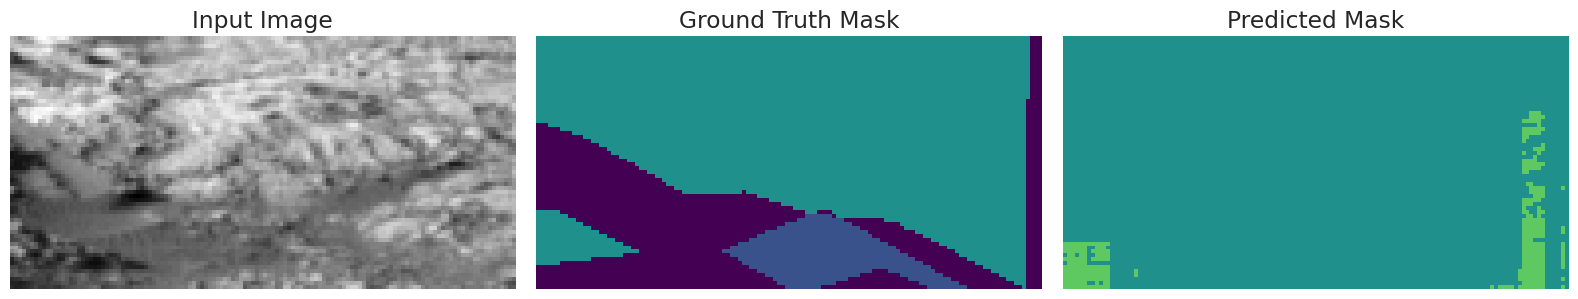

32/32 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.2071 - loss: 0.2998 - mean_iou: 0.0802 - val_accuracy: 0.2082 - val_loss: 0.0542 - val_mean_iou: 0.0778 - learning_rate: 0.0010
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 365ms/step - accuracy: 0.2130 - loss: -1.7021e-04 - mean_iou: 0.0671 - val_accuracy: 0.2075 - val_loss: -0.0811 - val_mean_iou: 0.0799 - learning_rate: 0.0010
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.2119 - loss: -0.0989 - mean_iou: 0.0700 - val_accuracy: 0.2076 - val_loss: -0.1281 - val_mean_iou: 0.0688 - learning_rate: 0.0010
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.2069 - loss: -0.1069 - mean_iou: 0.0630

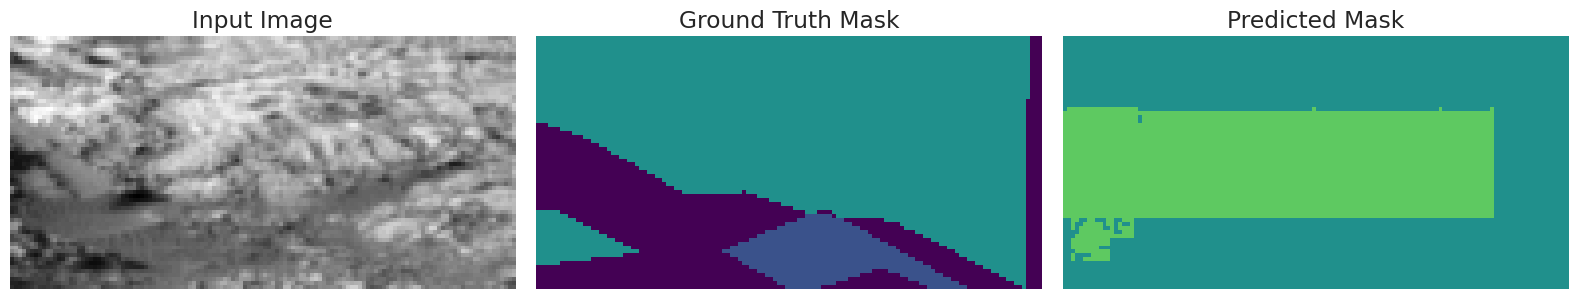

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.2070 - loss: -0.1071 - mean_iou: 0.0632 - val_accuracy: 0.2064 - val_loss: -0.1394 - val_mean_iou: 0.1063 - learning_rate: 0.0010
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.2046 - loss: -0.1206 - mean_iou: 0.0747 - val_accuracy: 0.2053 - val_loss: -0.1454 - val_mean_iou: 0.0730 - learning_rate: 0.0010
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.2100 - loss: -0.1341 - mean_iou: 0.0645 - val_accuracy: 0.1898 - val_loss: -0.1480 - val_mean_iou: 0.0780 - learning_rate: 0.0010
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.1959 - loss: -0.1454 - mean_iou: 0.0672

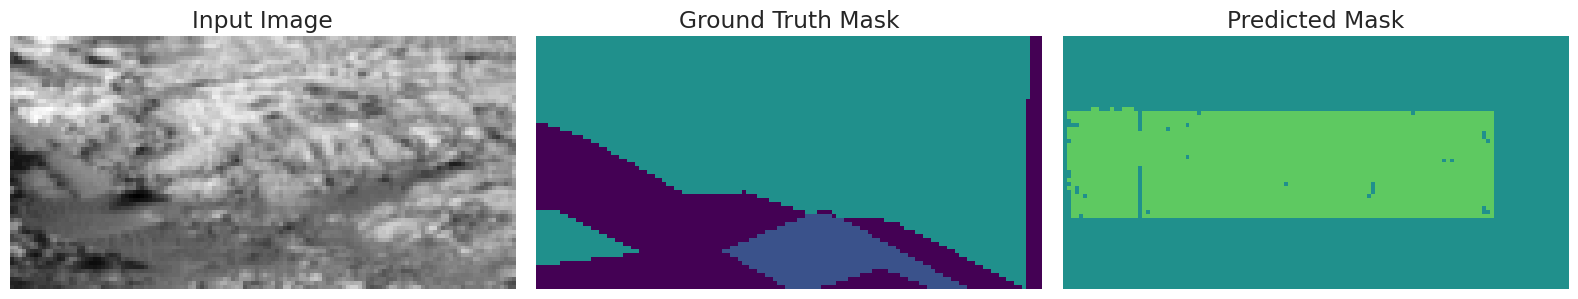

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.1963 - loss: -0.1455 - mean_iou: 0.0672 - val_accuracy: 0.1904 - val_loss: -0.1495 - val_mean_iou: 0.0886 - learning_rate: 0.0010
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.1916 - loss: -0.1467 - mean_iou: 0.0708 - val_accuracy: 0.1982 - val_loss: -0.1508 - val_mean_iou: 0.0779 - learning_rate: 0.0010
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2048 - loss: -0.1500 - mean_iou: 0.0728 - val_accuracy: 0.2071 - val_loss: -0.1515 - val_mean_iou: 0.0693 - learning_rate: 0.0010
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.1865 - loss: -0.1476 - mean_iou: 0.0737

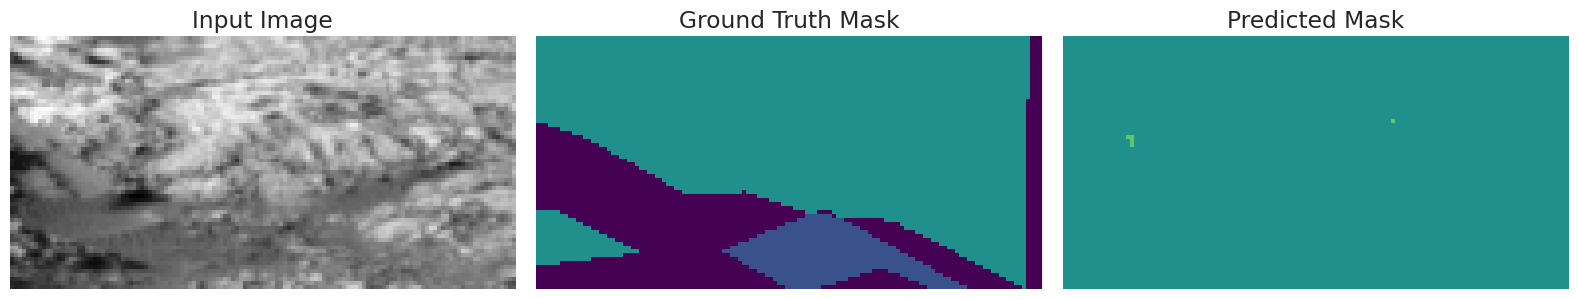

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 381ms/step - accuracy: 0.1866 - loss: -0.1477 - mean_iou: 0.0737 - val_accuracy: 0.2075 - val_loss: -0.1521 - val_mean_iou: 0.0688 - learning_rate: 0.0010
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - accuracy: 0.1890 - loss: -0.1528 - mean_iou: 0.0714 - val_accuracy: 0.2074 - val_loss: -0.1525 - val_mean_iou: 0.0688 - learning_rate: 0.0010
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.1953 - loss: -0.1543 - mean_iou: 0.0687 - val_accuracy: 0.2066 - val_loss: -0.1528 - val_mean_iou: 0.0687 - learning_rate: 0.0010
Epoch 13/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.2033 - loss: -0.1557 - mean_iou: 0.0666

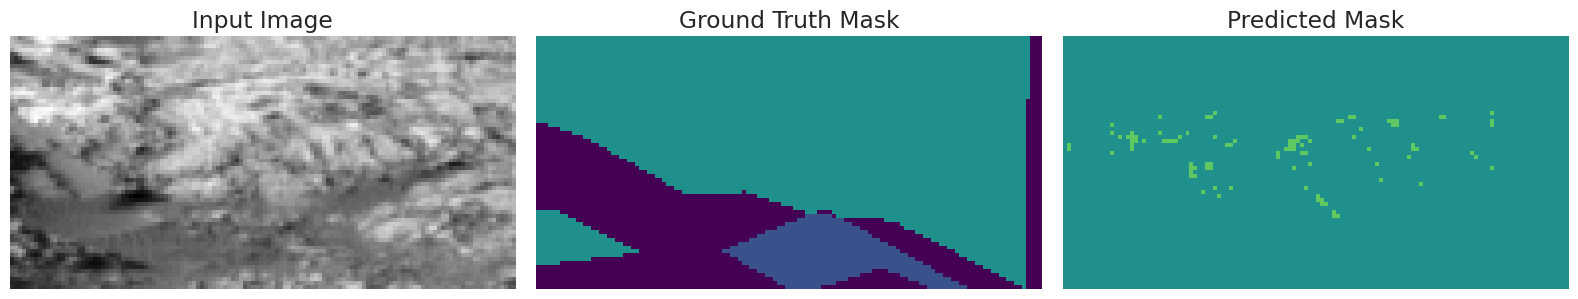

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.2034 - loss: -0.1557 - mean_iou: 0.0666 - val_accuracy: 0.2062 - val_loss: -0.1530 - val_mean_iou: 0.0686 - learning_rate: 0.0010
Epoch 14/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.2017 - loss: -0.1548 - mean_iou: 0.0667 - val_accuracy: 0.2050 - val_loss: -0.1533 - val_mean_iou: 0.0685 - learning_rate: 0.0010
Epoch 15/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.2048 - loss: -0.1557 - mean_iou: 0.0648 - val_accuracy: 0.2037 - val_loss: -0.1535 - val_mean_iou: 0.0684 - learning_rate: 0.0010
Epoch 16/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.2083 - loss: -0.1559 - mean_iou: 0.0636

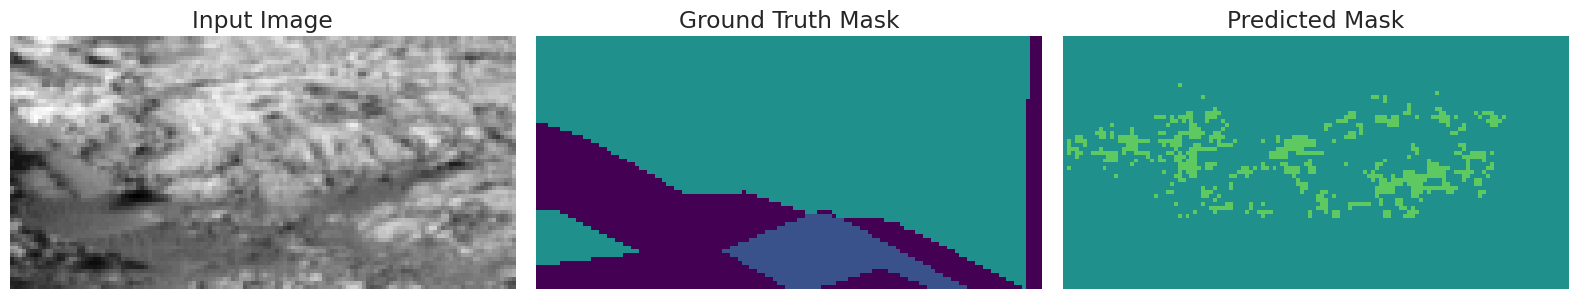

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.2086 - loss: -0.1559 - mean_iou: 0.0636 - val_accuracy: 0.2015 - val_loss: -0.1536 - val_mean_iou: 0.0683 - learning_rate: 0.0010
Epoch 17/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2108 - loss: -0.1561 - mean_iou: 0.0629 - val_accuracy: 0.1993 - val_loss: -0.1537 - val_mean_iou: 0.0684 - learning_rate: 0.0010
Epoch 18/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2133 - loss: -0.1558 - mean_iou: 0.0629 - val_accuracy: 0.1975 - val_loss: -0.1538 - val_mean_iou: 0.0686 - learning_rate: 0.0010
Epoch 19/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2076 - loss: -0.1550 - mean_iou: 0.0625

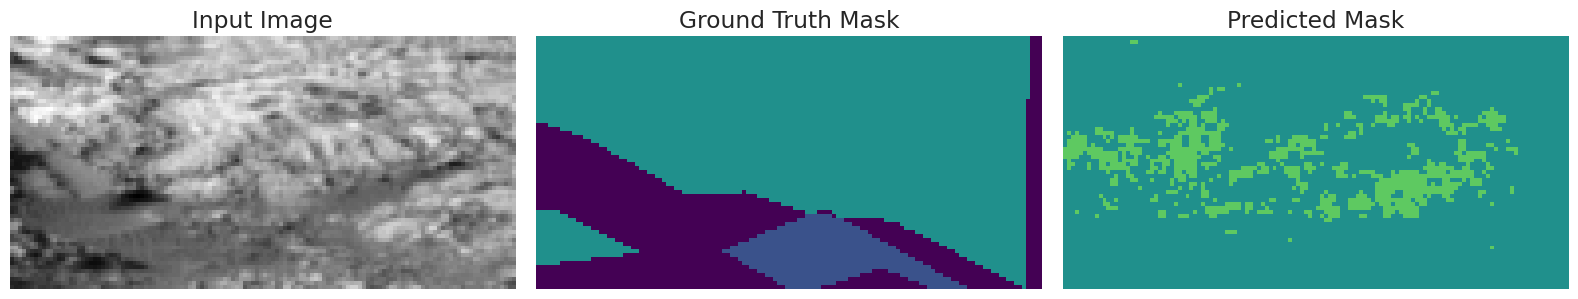

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step - accuracy: 0.2080 - loss: -0.1551 - mean_iou: 0.0626 - val_accuracy: 0.1974 - val_loss: -0.1538 - val_mean_iou: 0.0687 - learning_rate: 0.0010
Epoch 20/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.2083 - loss: -0.1556 - mean_iou: 0.0620 - val_accuracy: 0.1962 - val_loss: -0.1539 - val_mean_iou: 0.0688 - learning_rate: 0.0010
Epoch 21/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.2094 - loss: -0.1561 - mean_iou: 0.0621 - val_accuracy: 0.1951 - val_loss: -0.1539 - val_mean_iou: 0.0690 - learning_rate: 0.0010
Epoch 22/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.2116 - loss: -0.1560 - mean_iou: 0.0611

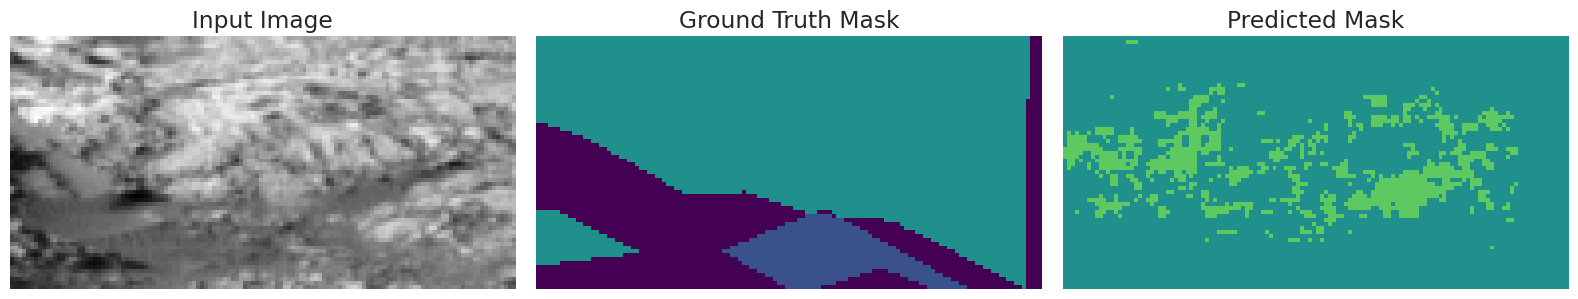

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.2119 - loss: -0.1560 - mean_iou: 0.0611 - val_accuracy: 0.1954 - val_loss: -0.1540 - val_mean_iou: 0.0691 - learning_rate: 0.0010
Epoch 23/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2078 - loss: -0.1563 - mean_iou: 0.0606 - val_accuracy: 0.1948 - val_loss: -0.1540 - val_mean_iou: 0.0692 - learning_rate: 0.0010
Epoch 24/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.2069 - loss: -0.1570 - mean_iou: 0.0599 - val_accuracy: 0.1928 - val_loss: -0.1540 - val_mean_iou: 0.0695 - learning_rate: 0.0010
Epoch 25/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2090 - loss: -0.1559 - mean_iou: 0.0619

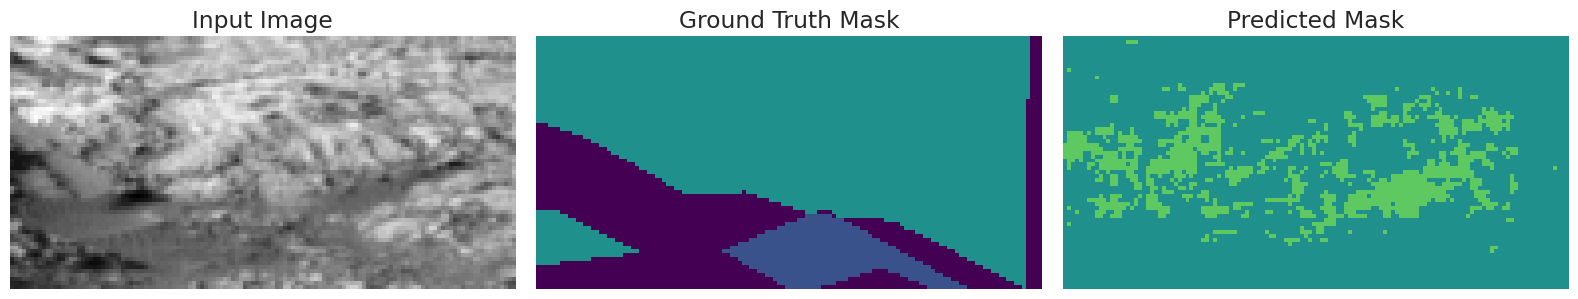

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step - accuracy: 0.2094 - loss: -0.1559 - mean_iou: 0.0619 - val_accuracy: 0.1932 - val_loss: -0.1541 - val_mean_iou: 0.0695 - learning_rate: 0.0010
Epoch 26/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step - accuracy: 0.2138 - loss: -0.1569 - mean_iou: 0.0620 - val_accuracy: 0.1934 - val_loss: -0.1541 - val_mean_iou: 0.0695 - learning_rate: 0.0010
Epoch 27/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - accuracy: 0.2125 - loss: -0.1560 - mean_iou: 0.0640 - val_accuracy: 0.1969 - val_loss: -0.1541 - val_mean_iou: 0.0691 - learning_rate: 0.0010
Epoch 28/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2144 - loss: -0.1559 - mean_iou: 0.0614

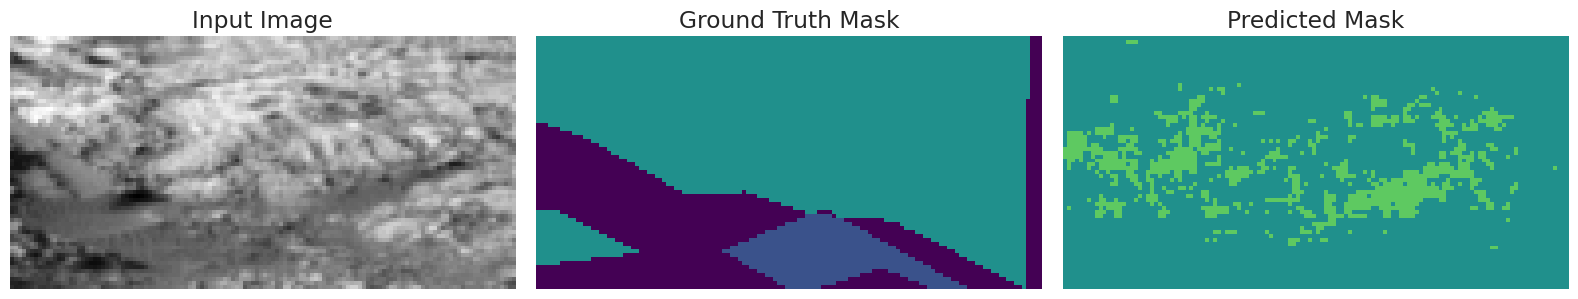

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step - accuracy: 0.2147 - loss: -0.1559 - mean_iou: 0.0614 - val_accuracy: 0.1980 - val_loss: -0.1541 - val_mean_iou: 0.0691 - learning_rate: 0.0010
Epoch 29/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.2106 - loss: -0.1558 - mean_iou: 0.0601 - val_accuracy: 0.2001 - val_loss: -0.1541 - val_mean_iou: 0.0691 - learning_rate: 0.0010
Epoch 30/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2120 - loss: -0.1565 - mean_iou: 0.0599 - val_accuracy: 0.1992 - val_loss: -0.1542 - val_mean_iou: 0.0693 - learning_rate: 0.0010
Epoch 31/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.2213 - loss: -0.1568 - mean_iou: 0.0628

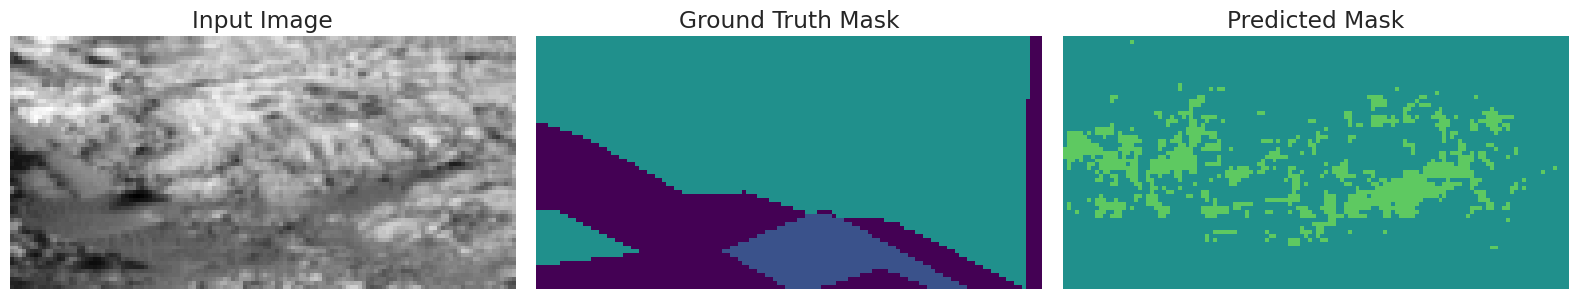

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step - accuracy: 0.2215 - loss: -0.1568 - mean_iou: 0.0628 - val_accuracy: 0.1986 - val_loss: -0.1542 - val_mean_iou: 0.0694 - learning_rate: 0.0010
Epoch 32/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.2173 - loss: -0.1568 - mean_iou: 0.0620 - val_accuracy: 0.1980 - val_loss: -0.1542 - val_mean_iou: 0.0695 - learning_rate: 0.0010
Epoch 33/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2198 - loss: -0.1563 - mean_iou: 0.0621 - val_accuracy: 0.1977 - val_loss: -0.1542 - val_mean_iou: 0.0696 - learning_rate: 0.0010
Epoch 34/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.2155 - loss: -0.1562 - mean_iou: 0.0625

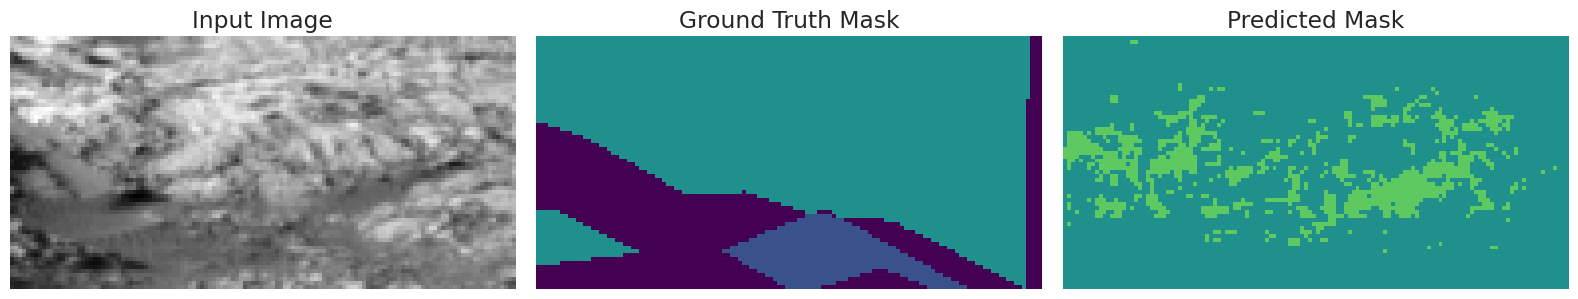

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step - accuracy: 0.2159 - loss: -0.1562 - mean_iou: 0.0625 - val_accuracy: 0.1981 - val_loss: -0.1542 - val_mean_iou: 0.0695 - learning_rate: 0.0010
Epoch 35/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2151 - loss: -0.1559 - mean_iou: 0.0601 - val_accuracy: 0.1974 - val_loss: -0.1542 - val_mean_iou: 0.0697 - learning_rate: 0.0010
Epoch 36/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.2166 - loss: -0.1564 - mean_iou: 0.0606 - val_accuracy: 0.2000 - val_loss: -0.1542 - val_mean_iou: 0.0696 - learning_rate: 0.0010
Epoch 37/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2114 - loss: -0.1561 - mean_iou: 0.0598

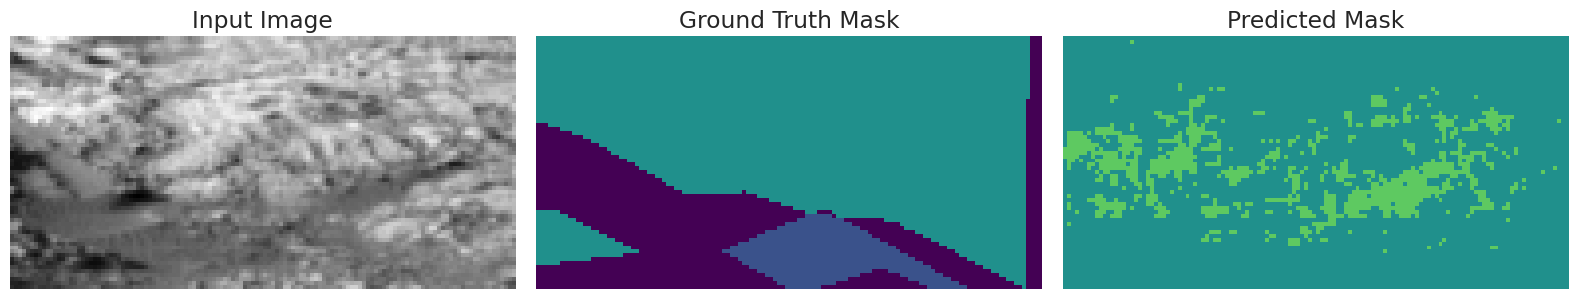

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step - accuracy: 0.2118 - loss: -0.1561 - mean_iou: 0.0599 - val_accuracy: 0.1995 - val_loss: -0.1542 - val_mean_iou: 0.0697 - learning_rate: 0.0010
Epoch 38/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.2132 - loss: -0.1559 - mean_iou: 0.0618 - val_accuracy: 0.1993 - val_loss: -0.1543 - val_mean_iou: 0.0698 - learning_rate: 0.0010
Epoch 39/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.2173 - loss: -0.1563 - mean_iou: 0.0616 - val_accuracy: 0.2015 - val_loss: -0.1543 - val_mean_iou: 0.0696 - learning_rate: 0.0010
Epoch 40/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.2147 - loss: -0.1572 - mean_iou: 0.0659

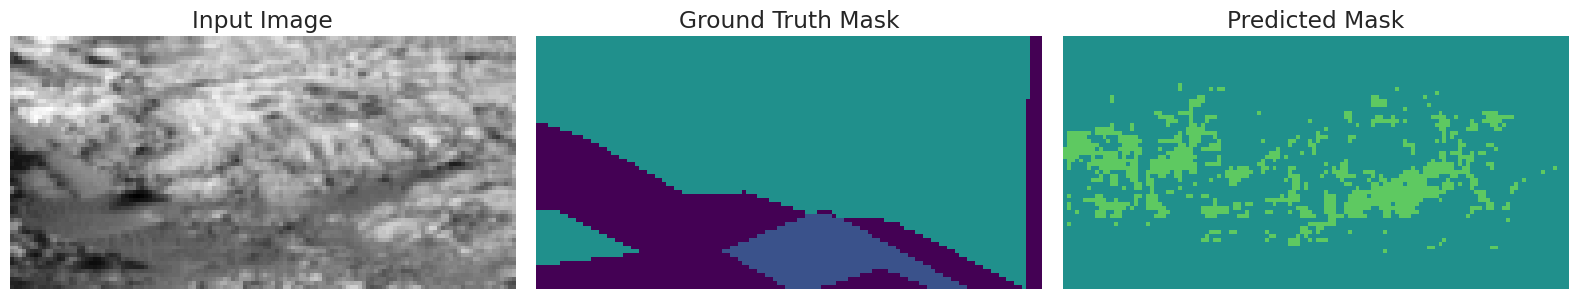

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 375ms/step - accuracy: 0.2150 - loss: -0.1572 - mean_iou: 0.0658 - val_accuracy: 0.2005 - val_loss: -0.1543 - val_mean_iou: 0.0699 - learning_rate: 0.0010
Epoch 41/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2167 - loss: -0.1559 - mean_iou: 0.0654 - val_accuracy: 0.1998 - val_loss: -0.1543 - val_mean_iou: 0.0700 - learning_rate: 0.0010
Epoch 42/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.2146 - loss: -0.1568 - mean_iou: 0.0602 - val_accuracy: 0.1995 - val_loss: -0.1543 - val_mean_iou: 0.0701 - learning_rate: 0.0010
Epoch 43/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.2199 - loss: -0.1564 - mean_iou: 0.0630

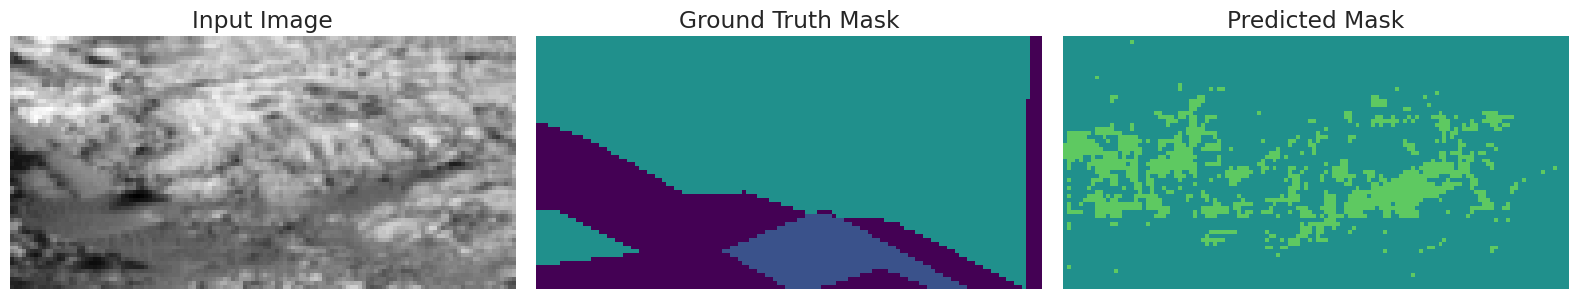

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.2201 - loss: -0.1564 - mean_iou: 0.0631 - val_accuracy: 0.1993 - val_loss: -0.1543 - val_mean_iou: 0.0703 - learning_rate: 0.0010
Epoch 44/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2130 - loss: -0.1551 - mean_iou: 0.0597 - val_accuracy: 0.1974 - val_loss: -0.1543 - val_mean_iou: 0.0707 - learning_rate: 0.0010
Epoch 45/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.2129 - loss: -0.1560 - mean_iou: 0.0600 - val_accuracy: 0.1978 - val_loss: -0.1543 - val_mean_iou: 0.0705 - learning_rate: 0.0010
Epoch 46/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.2149 - loss: -0.1561 - mean_iou: 0.0633

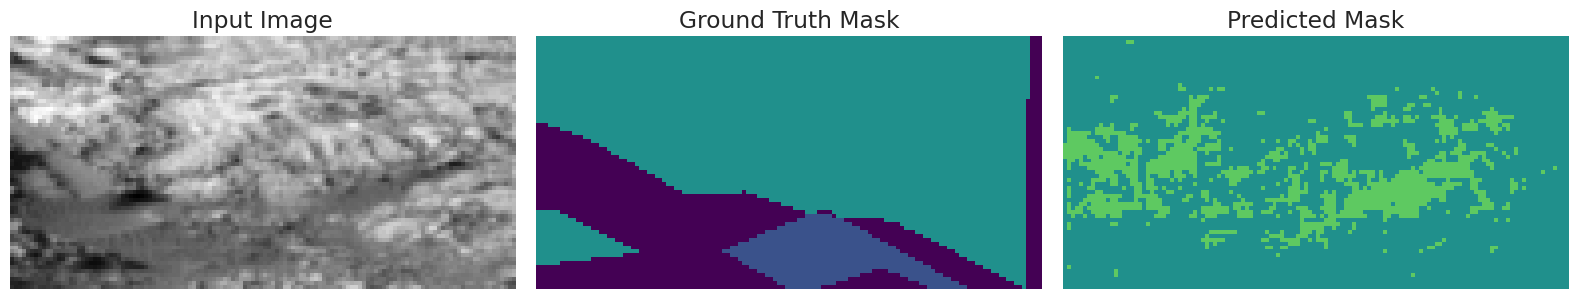

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step - accuracy: 0.2152 - loss: -0.1562 - mean_iou: 0.0633 - val_accuracy: 0.1971 - val_loss: -0.1543 - val_mean_iou: 0.0706 - learning_rate: 0.0010
Epoch 47/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.2139 - loss: -0.1559 - mean_iou: 0.0601 - val_accuracy: 0.1973 - val_loss: -0.1543 - val_mean_iou: 0.0705 - learning_rate: 0.0010
Epoch 48/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.2175 - loss: -0.1574 - mean_iou: 0.0605 - val_accuracy: 0.1978 - val_loss: -0.1543 - val_mean_iou: 0.0701 - learning_rate: 0.0010
Epoch 49/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2136 - loss: -0.1550 - mean_iou: 0.0611

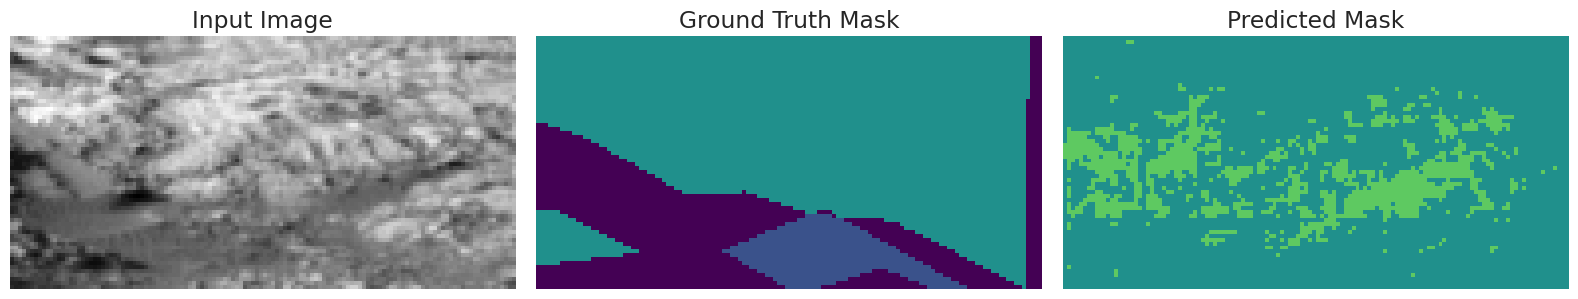

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step - accuracy: 0.2139 - loss: -0.1551 - mean_iou: 0.0611 - val_accuracy: 0.1976 - val_loss: -0.1543 - val_mean_iou: 0.0701 - learning_rate: 0.0010
Epoch 50/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.2152 - loss: -0.1569 - mean_iou: 0.0627 - val_accuracy: 0.1975 - val_loss: -0.1543 - val_mean_iou: 0.0701 - learning_rate: 0.0010
Epoch 51/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step - accuracy: 0.2189 - loss: -0.1568 - mean_iou: 0.0633 - val_accuracy: 0.1980 - val_loss: -0.1543 - val_mean_iou: 0.0701 - learning_rate: 0.0010
Epoch 52/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2146 - loss: -0.1575 - mean_iou: 0.0603

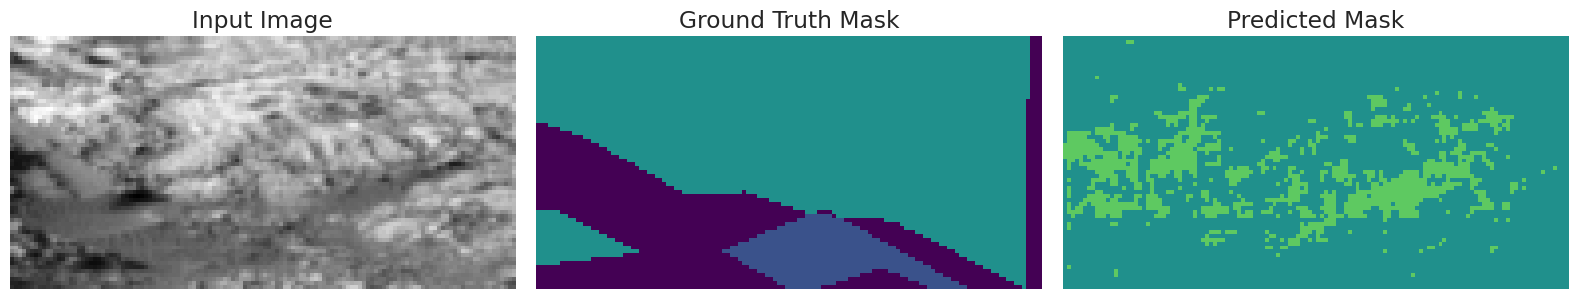

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.2150 - loss: -0.1575 - mean_iou: 0.0604 - val_accuracy: 0.1990 - val_loss: -0.1543 - val_mean_iou: 0.0699 - learning_rate: 0.0010
Epoch 53/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - accuracy: 0.2141 - loss: -0.1553 - mean_iou: 0.0594 - val_accuracy: 0.1989 - val_loss: -0.1543 - val_mean_iou: 0.0699 - learning_rate: 0.0010
Epoch 54/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.2174 - loss: -0.1569 - mean_iou: 0.0617 - val_accuracy: 0.1981 - val_loss: -0.1543 - val_mean_iou: 0.0699 - learning_rate: 0.0010
Final validation Mean Intersection Over Union: 10.63%
Model saved to model_241212_220509.keras


In [29]:
# Train the model
history = model.fit( 
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, learning_rate, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file 
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

#del model

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔮 Predictions on the Test Set

In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
'''
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")
'''

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
# Plot some predictions 
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions (excluding 0)
num_classes = len(classes) # Excluding background

# Create colormap based on the number of classes
colormap = create_segmentation_colormap(num_classes)

# Create a list to store the handles for the legend (only once)
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# After all images have been plotted, add the legend once
# We collect handles for the legend here, only once
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

In [ ]:
del model